# Creating the External Forcing Conditions

First, import packages to re-create and visualize the model fields here:

In [1]:
import time
from pathlib import Path

import cmocean.cm as cm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange

from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal
from eccoseas.ecco import exf

Define the `Path` object for the directories of project root, data, and input.

In [2]:
# define the input directory
PROJ_ROOT = Path("..").resolve()
DATA_DIR = PROJ_ROOT / "data"
INPUT_DIR = PROJ_ROOT / "input"

## External Forcing Source Files
For this example, I will use the external forcing fields from the ECCO Version 5 state estimate. I will prepare these fields in 5 steps:
1. download 7 external forcing fields used in the ECCO model
2. read the external forcing fields used in the ECCO model as well as the ECCO grid
3. read in the bathymetry for my model as well as its grid
4. interpolate the ECCO fields onto my model grid and store each as a binary file
5. plot the interpolated fields to ensure they look as expected

### Step 1: Download the ECCO external forcing fields

To begin, download the ECCO external forcing fields used in the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/era_xx). For my model, I downloaded the following list of files for my year of interest (2009):

| Variable | File Name                          |
|----------|------------------------------------|
| ATEMP    | EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl |
| AQH      | EIG_spfh2m_plus_ECCO_v4r1_ctrl     |
| SWDOWN   | EIG_dsw_plus_ECCO_v4r1_ctrl        |
| LWDOWN   | EIG_dlw_plus_ECCO_v4r1_ctrl        |
| UWIND    | EIG_u10m                           |
| VWIND    | EIG_v10m                           |
| PRECIP   | EIG_rain_plus_ECCO_v4r1_ctrl       |


### Step 2: Read in the external forcing fields

The `exf` module from the `eccoseas` package is used to read in the ECCO fields.

In [5]:
# make a file dictionary to loop over
FILE_PREFIX_DICT = {
    "ATEMP": "EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl",
    "AQH": "EIG_spfh2m_plus_ECCO_v4r1_ctrl",
    "SWDOWN": "EIG_dsw_plus_ECCO_v4r1_ctrl",
    "LWDOWN": "EIG_dlw_plus_ECCO_v4r1_ctrl",
    "UWIND": "EIG_u10m",
    "VWIND": "EIG_v10m",
    "PRECIP": "EIG_rain_plus_ECCO_v4r1_ctrl",
}

# full list - uncomment after testing
VARIABLE_NAMES = list(FILE_PREFIX_DICT.keys())

# make a list to hold all of the exf grid
exf_grids = []
YEAR = 2009

# loop through each variable to read in the grid
for field in tqdm(VARIABLE_NAMES):
    exf_lon, exf_lat, exf_grid = exf.read_ecco_exf_file(
        str(DATA_DIR), FILE_PREFIX_DICT[field], YEAR
    )
    exf_grids.append(exf_grid)

100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


With an eye toward the interpolation that will come in step 4, I will make 2D grids of longitudes and latitudes to use in the interpolation

In [6]:
EXF_LON_MG, EXF_LAT_MG = np.meshgrid(exf_lon, exf_lat)
ECCO_POINTS = np.column_stack([EXF_LON_MG.ravel(), EXF_LAT_MG.ravel()])

In addition, I will make a mask to determine where the interpolation will take place. Since the external forcing conditions are provided everywhere, I just set the entire grid to 1:

In [7]:
ECCO_MASK = np.ones((np.size(EXF_LON_MG),))

### Step 3: Read in the Model Grid
Next, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details) and visualized to double check

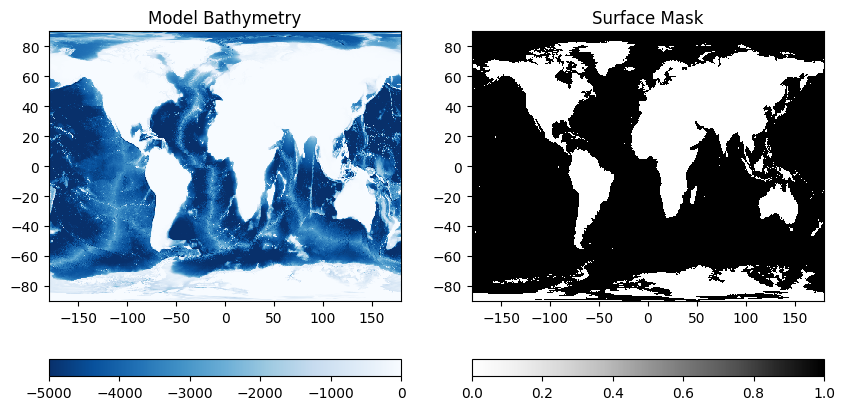

In [11]:
# Define the parameters that will be used in the data file.
DEL_X = 0.5
DEL_Y = 0.5
XG_ORIGIN = -180
YG_ORIGIN = -90
N_COLS = 720
N_ROWS = 360

# # Recreate the grids that will be used in the model.
XC = np.arange(XG_ORIGIN + DEL_X / 2, XG_ORIGIN + N_COLS * DEL_X + DEL_X / 2, DEL_X)
YC = np.arange(YG_ORIGIN + DEL_Y / 2, YG_ORIGIN + N_ROWS * DEL_Y + DEL_Y / 2, DEL_Y)
XC_MG, YC_MG = np.meshgrid(XC, YC)

# read in the bathymetry file
BATHY_FILE = INPUT_DIR / "earth_bathymetry.bin"
BATHY = np.fromfile(str(BATHY_FILE), ">f4").reshape(np.shape(XC_MG))

# create mask to determine where the inerpolation will take place by using the hFac module from the eccoseas package
SURFACE_MASK = hFac.create_surface_hFacC_grid(BATHY, delR=1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
C = plt.pcolormesh(XC_MG, YC_MG, BATHY, vmin=-5000, vmax=0, cmap="Blues_r")
plt.colorbar(C, orientation="horizontal")
plt.title("Model Bathymetry")

plt.subplot(1, 2, 2)
C = plt.pcolormesh(XC_MG, YC_MG, SURFACE_MASK, vmin=0, vmax=1, cmap="Greys")
plt.colorbar(C, orientation="horizontal")
plt.title("Surface Mask")

plt.show()

### Step 4: Interpolate the Fields onto the Model Grid

Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

#### &#x2757; Warning

This code block may take a while to run. Further, it will generate 7 files sized ~500MB. Plan accordingly.

In [13]:
# ensure the output folder exists
if not (INPUT_DIR / "exf").exists():
    (INPUT_DIR / "exf").mkdir()

# --- 1. Define the Worker Function (Runs on 1 Core) ---
def interpolate_single_timestep(timestep_idx, val_slice, ecco_points, ecco_mask,
                                xc, yc, surf_mask):
    """
    Interpolates a single time slice.
    Using 'val_slice' ensures we only pass necessary data to the worker.
    """
    # Interpolation logic
    interp = horizontal.downscale_2D_points_with_zeros(
        ecco_points,
        val_slice, # 1D array of values for this timestep
        ecco_mask,
        xc,
        yc,
        surf_mask
    )
    return interp

# --- 2. Main Processing Function ---
def process_all_variables_optimized(variable_names, exf_grids, ecco_points, ecco_mask,
                                    XC, YC, surface_mask, input_dir, year):

    input_path = Path(input_dir) / 'exf'
    input_path.mkdir(parents=True, exist_ok=True)

    total_start = time.time()

    # Loop through variables SEQUENTIALLY to save RAM
    # But process time steps in PARALLEL to maximize CPU
    for var_name, exf_grid in zip(variable_names, exf_grids):
        print(f"\nProcessing {var_name}...")
        var_start = time.time()

        n_timesteps = exf_grid.shape[0]

        # --- THE OPTIMIZATION: PARALLEL TIME LOOP ---
        # n_jobs=-1 tells joblib to use ALL available threads (32 on Ryzen)
        # mmap_mode='r' (optional) prevents RAM duplication if data is on disk
        results = Parallel(n_jobs=-1, backend='loky')(
            delayed(interpolate_single_timestep)(
                t,
                exf_grid[t, :, :].ravel(), # Pass flattened slice
                ecco_points,
                ecco_mask,
                XC,
                YC,
                surface_mask
            ) for t in tqdm(range(n_timesteps), desc=f"Interpolating {var_name}")
        )

        # Stack results back into 3D array (Time, Lat, Lon)
        interpolated_grid = np.array(results)

        # --- Unit Conversions ---
        if var_name == 'ATEMP':
            interpolated_grid += 273.15 # Celsius to Kelvin
        elif var_name in ['SWDOWN', 'LWDOWN']:
            interpolated_grid *= -1 # Downward flux convention

        # --- Write to Disk ---
        output_file = input_path / f"{var_name}_{year}"
        # Save as Big Endian Float32 (Standard MITgcm format)
        interpolated_grid.astype('>f4').tofile(str(output_file))

        elapsed = (time.time() - var_start) / 60
        print(f"Finished {var_name}: Saved to {output_file}")
        print(f"Time taken: {elapsed:.2f} mins")

    total_elapsed = (time.time() - total_start) / 60
    print(f"\nTotal Processing Time: {total_elapsed:.2f} mins")

# --- Usage Example (Assuming data is loaded) ---
process_all_variables_optimized(VARIABLE_NAMES, exf_grids, ECCO_POINTS, ECCO_MASK, XC_MG, YC_MG, SURFACE_MASK, INPUT_DIR, YEAR)


Processing ATEMP...


Interpolating ATEMP: 100%|██████████| 1460/1460 [02:15<00:00, 10.77it/s]


Finished ATEMP: Saved to /home/jon/src/sjsu/cs185c-fall2024/project/input/exf/ATEMP_2009
Time taken: 2.39 mins

Processing AQH...


Interpolating AQH: 100%|██████████| 1460/1460 [02:10<00:00, 11.18it/s]


Finished AQH: Saved to /home/jon/src/sjsu/cs185c-fall2024/project/input/exf/AQH_2009
Time taken: 2.30 mins

Processing SWDOWN...


Interpolating SWDOWN: 100%|██████████| 1460/1460 [02:10<00:00, 11.16it/s]


Finished SWDOWN: Saved to /home/jon/src/sjsu/cs185c-fall2024/project/input/exf/SWDOWN_2009
Time taken: 2.31 mins

Processing LWDOWN...


Interpolating LWDOWN: 100%|██████████| 1460/1460 [02:09<00:00, 11.27it/s]


Finished LWDOWN: Saved to /home/jon/src/sjsu/cs185c-fall2024/project/input/exf/LWDOWN_2009
Time taken: 2.28 mins

Processing UWIND...


Interpolating UWIND: 100%|██████████| 1460/1460 [02:11<00:00, 11.14it/s]


Finished UWIND: Saved to /home/jon/src/sjsu/cs185c-fall2024/project/input/exf/UWIND_2009
Time taken: 2.31 mins

Processing VWIND...


Interpolating VWIND: 100%|██████████| 1460/1460 [02:10<00:00, 11.15it/s]


Finished VWIND: Saved to /home/jon/src/sjsu/cs185c-fall2024/project/input/exf/VWIND_2009
Time taken: 2.30 mins

Processing PRECIP...


Interpolating PRECIP: 100%|██████████| 1460/1460 [02:10<00:00, 11.19it/s]


Finished PRECIP: Saved to /home/jon/src/sjsu/cs185c-fall2024/project/input/exf/PRECIP_2009
Time taken: 2.30 mins

Total Processing Time: 16.18 mins


### Step 5: Plotting the External Forcing Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


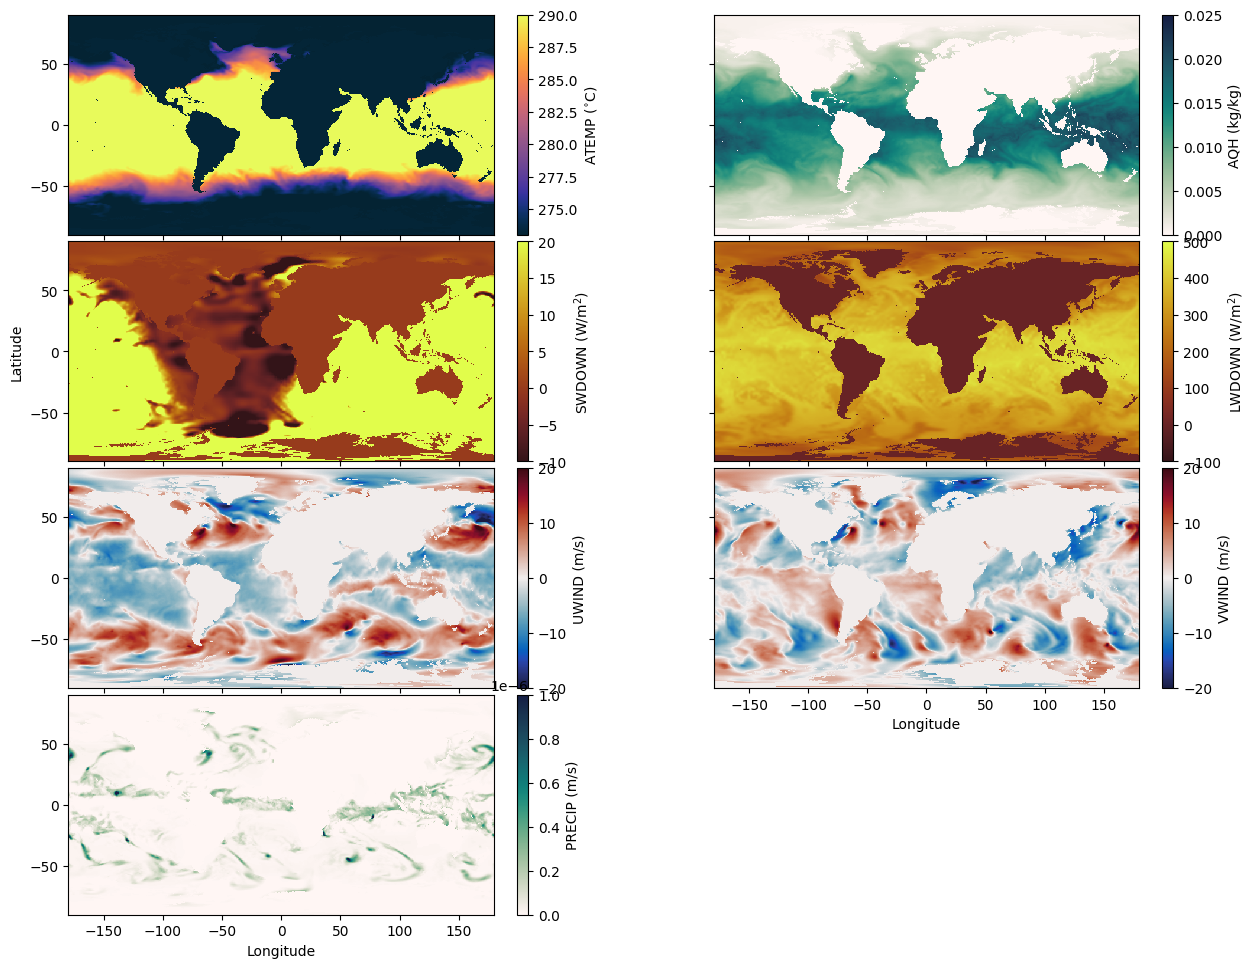

In [20]:
META_DICT = {
    "ATEMP": [273, 290, cm.thermal, "$^{\\circ}$C"],
    "AQH": [0, 0.025, cm.tempo, "kg/kg"],
    "PRECIP": [0, 1e-6, cm.tempo, "m/s"],
    "SWDOWN": [-10, 20, cm.solar, "W/m$^2$"],
    "LWDOWN": [-100, 500, cm.solar, "W/m$^2$"],
    "UWIND": [-20, 20, cm.balance, "m/s"],
    "VWIND": [-20, 20, cm.balance, "m/s"],
    "RUNOFF": [0, 2e-8, cm.tempo, "m/s"],
}

YEAR = 2009
fig = plt.figure(figsize=(14, 10))
GS = GridSpec(
    4, 2, wspace=0.4, hspace=0.03, left=0.11, right=0.9, top=0.95, bottom=0.05
)

for i in trange(len(VARIABLE_NAMES)):
    variable_name = VARIABLE_NAMES[i]

    earth_exf_grid = np.fromfile(
        str(INPUT_DIR / "exf" / f"{variable_name}_{YEAR}"), ">f4"
    )
    earth_exf_grid = earth_exf_grid.reshape((np.shape(exf_grid)[0], np.shape(XC_MG)[0], np.shape(XC_MG)[1]))

    # choose just the first timestep for plotting
    earth_exf_grid = earth_exf_grid[0, :, :]

    ax1 = fig.add_subplot(GS[i])
    C = plt.pcolormesh(
        XC,
        YC,
        earth_exf_grid,
        vmin=META_DICT[VARIABLE_NAMES[i]][0],
        vmax=META_DICT[VARIABLE_NAMES[i]][1],
        cmap=META_DICT[VARIABLE_NAMES[i]][2],
    )
    plt.colorbar(
        C,
        label=VARIABLE_NAMES[i] + " (" + META_DICT[VARIABLE_NAMES[i]][3] + ")",
        fraction=0.026,
    )

    if i < 5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel("Longitude")
    if i % 2 == 1:
        plt.gca().set_yticklabels([])
    if i == 7:
        plt.gca().axis("off")
    if i == 2:
        plt.gca().set_ylabel("Latitude")

plt.show()